# CS 109B - Course Project - Team 14
## Text Mining - The Movie Database - Movie Plots

In [38]:
import numpy as np
import os.path as op
import pandas as pd
import re

from matplotlib import pyplot as plt
from sklearn.cross_validation import KFold
from sklearn.model_selection import train_test_split as sk_split
from sklearn.decomposition import TruncatedSVD as tSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.io import mmwrite
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import LogisticRegression as Log_Reg
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.metrics import hamming_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC

from IPython.display import display, HTML, Markdown
%matplotlib inline
plt.style.use('ggplot') 
def printmd(string):
    display(Markdown(string))

In [39]:
genres = ["Action", "Adventure", "Animation", "Comedy", "Crime", "Documentary", "Drama", \
            "Family", "Fantasy", "History", "Horror", "Music", "Musical", "Mystery", \
          "Romance", "Sci-Fi", "Thriller", "War", "Western"]

num_genres = len(genres)

train_percent = 80

## Step 1: Load and Clean Data

In [40]:
# helper function to select the columns of interest from the data set
def Select_Data(data):
    
    features_to_select = ["plot", 'imdb_id'] + genres
    data_select = data[features_to_select]
    data_select.columns = ["Plot", "Imdb_Id"] + genres
    
    return data_select

In [41]:
# helper function to filter the data set down to rows of interest
def Filter_Data(data):
    
    # set flags for filtering
    status_flags =  ~data.Plot.isnull() & \
                    ~data.Plot.str.match('NA', na = False)          
                
    # filter rows per flags above
    data_filter = data.ix[status_flags, :].reset_index(drop = True)
    
    return data_filter

In [42]:
# helper function to clean data
def Clean_Data(data):
    data_clean = data.copy()
    data_clean.Plot = data_clean.Plot.str.replace("\n|\r", ' ')
        
    return data_clean

In [43]:
def Preprocess_Dataset():
    clean_data_filename = "clean_data_with_Y.csv"

    # preprocess data set and save result as new file
    if not op.isfile(clean_data_filename):
        data_raw = pd.read_csv("imdb_movies_trim.csv")
        data_select = Select_Data(data_raw)
        data_filter = Filter_Data(data_select)
        data_clean = Clean_Data(data_filter)
        data_clean.to_csv(clean_data_filename, index = False)

    # read pre-processed sample data file
    data_clean2 = pd.read_csv(clean_data_filename)
        
    return data_clean2

In [44]:
# pre-process or load data for analysis
data = Preprocess_Dataset()   

# set boolean and string column data types
data.Plot = data.Plot.astype('str')

# split data into train vs. test sets
data_train, data_test = sk_split(data, train_size = train_percent / 100.0)
x_train = data_train.Plot
x_test = data_test.Plot
y_train = data_train.loc[:, genres]
y_test = data_test.loc[:, genres]

In [45]:
# get overview of data
print
print("Data dimensions: " + str(data_train.shape))
display(data_train.head())


Data dimensions: (28098, 21)


,Plot,Imdb_Id,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,...,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
23151,"On a ski trip, rich, idle Peter Kirk pursues a...",34407,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
29699,"Inspired by a magician named Shiny Chariot, th...",2704454,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7149,"Jenny Nix, wife of eminent child psychologist ...",105217,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
24740,Nora is a stewardess for ATI Airlines. She lan...,71344,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25965,7-year-old Bertil's parents are at work and Be...,100264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
# summarize data
data_train.describe()

,Imdb_Id,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,2.809800e+04,28098.000000,28098.000000,28098.000000,28098.000000,28098.000000,28098.000000,28098.000000,28098.000000,28098.000000,28098.000000,28098.000000,28098.000000,28098.000000,28098.000000,28098.000000,28098.000000,28098.000000,28098.000000,28098.000000
mean,8.335975e+05,0.141896,0.102000,0.043775,0.322229,0.141006,0.087551,0.516015,0.069827,0.071571,0.042103,0.113745,0.036551,0.030750,0.076803,0.197772,0.076945,0.203609,0.045092,0.028472
std,1.124578e+06,0.348950,0.302654,0.204599,0.467339,0.348034,0.282645,0.499752,0.254860,0.257781,0.200827,0.317507,0.187659,0.172641,0.266283,0.398326,0.266509,0.402688,0.207510,0.166319
min,3.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.039150e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.502410e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.333477e+06,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6.098922e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Step 2: Create NLP Features

### Process Text

For the training data, we proceed with the following steps:
    
1. Stem words to reduce noise in the data
2. Fit a TF-IDF vectorizer and build a document-term matrix
3. Fit principal components and reduce the data

In [47]:
### set up word stemming

from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer(language = 'english', ignore_stopwords = True)
analyzer = TfidfVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

def take(n, seq):
    seq = iter(seq)
    result = []
    try:
        for i in range(n):
            result.append(seq.next())
    except StopIteration:
        pass
    
    return result

#### Training Data

In [48]:
# stem words in Plot field (train)
for index in range(x_train.shape[0]):
    x_train.values[index] = \
        " ".join(take(1000, stemmed_words(x_train.values[index])))

In [49]:
# create n-grams from plot (train)
vectorizer = TfidfVectorizer(stop_words = 'english', ngram_range = (1, 1))
vectorizer.fit(x_train.values)
plot_matrix_train = vectorizer.transform(x_train.values)
n, p = plot_matrix_train.shape
print plot_matrix_train.shape

# term_freqs_file = "term_freqs.mtx"
#if not op.isfile(term_freqs_file):
#    mmwrite(term_freqs_file, plot_matrix_train)

(28098, 59820)


In [50]:
# apply SVD to document-term matrix (train)
num_pc = 100
num_pc_qda = 10
tsvd = tSVD(n_components = num_pc)
tsvd.fit(plot_matrix_train)
x_train_pca = tsvd.transform(plot_matrix_train)
print
print("Cumulative percentage of variance explained: " + \
      str(round(tsvd.explained_variance_ratio_.sum(), 4)))


Cumulative percentage of variance explained: 0.0892


In [51]:
pc1 = tsvd.components_[0]
pc1_top_loadings = np.where(pc1 > 10**-1.5)

#### Testing Data

Vectorizer and principal-components transformations of the testing data are performed using fits from the training data.

In [52]:
# stem words in Plot field (test)
for index in range(data_test.shape[0]):
    x_test.values[index] = \
        " ".join(take(1000, stemmed_words(x_test.values[index])))

# create n-grams from plot (test)
plot_matrix_test = vectorizer.transform(x_test.values)

# apply SVD to document-term matrix (test)
x_test_pca = tsvd.transform(plot_matrix_test)

### Explore Terms

In [53]:
# print sample terms from plot
feature_names = np.array(vectorizer.get_feature_names()).reshape(-1, 1)
print "Total number of plots and terms: " + str(n) + " plots and " \
    + str(p) + " terms"
print
terms_df = pd.DataFrame(feature_names[1000:1010, 0], 
                        columns = ['Sample_Stemmed_Terms'])
display(terms_df)

Total number of plots and terms: 28098 plots and 59820 terms



,Sample_Stemmed_Terms
0,7ft
1,7pm
2,7th
3,7½
4,7ème
5,80
6,800
7,8000
8,800km
9,80s


In [54]:
# count words and vocabulary per plot
data_train.Word_Count = plot_matrix_train.sum(axis = 1)
data_train.Vocab_Count = (plot_matrix_train > 0).sum(axis = 1)

In [55]:
# create term dictionary
all_term_dict = zip(vectorizer.get_feature_names(),
                    np.asarray(plot_matrix_train.sum(axis = 0)).ravel())
all_term_dict_df = pd.DataFrame(all_term_dict).sort_values(by = [1], 
                                                           ascending = False)

In [56]:
# list top terms in dictionary
print
print "Most frequent stemmed terms in plots"
all_term_dict_df.columns = ['Stemmed_Term', 'Count']
all_term_dict_df.reset_index(drop = True).head(20)


Most frequent stemmed terms in plots


,Stemmed_Term,Count
0,life,430.507238
1,young,377.803986
2,love,371.314819
3,man,370.469078
4,year,350.169381
5,famili,346.738621
6,live,344.472342
7,friend,342.256436
8,new,339.080729
9,stori,303.590756


In [57]:
terms_df = pd.DataFrame(feature_names[pc1_top_loadings], columns = ['Term'])
printmd("#### Top loadings (terms) of principal component 1:")
printmd(terms_df.Term.str.cat(sep = ', '))

#### Top loadings (terms) of principal component 1:

age, agent, american, anoth, apart, arriv, attempt, away, base, beauti, becom, begin, believ, best, big, boy, break, bring, brother, busi, car, chang, child, children, citi, colleg, come, countri, coupl, crime, daughter, day, dead, deal, death, decid, die, differ, discov, does, doesn, dream, drug, end, escap, event, ex, experi, face, fall, famili, father, feel, fight, film, final, follow, forc, friend, gang, girl, girlfriend, goe, good, group, happen, having, head, help, high, home, hope, hous, howev, human, husband, includ, investig, involv, island, jack, job, john, journey, just, kid, kill, killer, know, later, lead, learn, leav, left, life, like, littl, live, local, long, look, love, make, man, mani, marri, marriag, meet, men, money, mother, movi, murder, music, mysteri, need, new, night, offic, old, order, parent, parti, past, peopl, person, place, plan, play, polic, power, prison, problem, real, realiz, relationship, return, run, save, school, search, secret, set, sister, small, someth, son, soon, star, start, stop, stori, struggl, student, success, surviv, team, teenag, tell, thing, time, togeth, town, train, travel, tri, troubl, true, turn, use, villag, want, war, way, wife, woman, women, work, world, year, york, young

These top loadings show a variety of terms used to distinguish one genre from another.

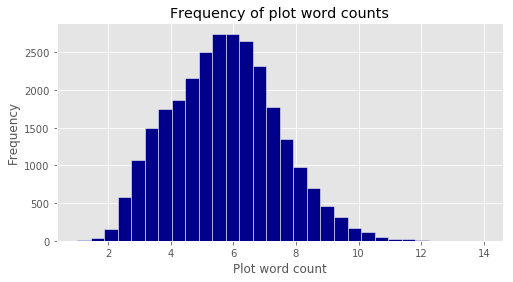

In [58]:
# plot histogram of word counts per plot
print
fig = plt.figure(figsize = (8, 4))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data_train.Word_Count, bins = 30, color = 'darkblue', 
        edgecolor = 'white')
ax.set_title("Frequency of plot word counts")
ax.set_xlabel("Plot word count")
ax.set_ylabel("Frequency")
plt.show()

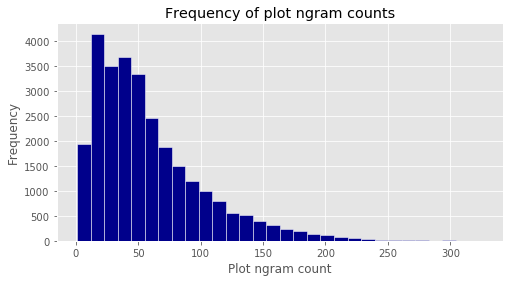

In [59]:
# plot histogram of vocabulary counts per plot
print
fig = plt.figure(figsize = (8, 4))
ax = fig.add_subplot(1, 1, 1)
ax.hist(data_train.Vocab_Count, bins = 30, color = 'darkblue', 
        edgecolor = 'white')
ax.set_title("Frequency of plot ngram counts")
ax.set_xlabel("Plot ngram count")
ax.set_ylabel("Frequency")
plt.show()

## Step 3: Modeling

Let's explore a variety of methods, choosing the most effective one(s).

### Utility Functions

In [60]:
# define model codes
log_reg = 2
lda = 3
qda = 4
knn = 5
rfc = 6
gbc = 7
svm = 8
dtc = 9
nb = 10

In [61]:
# function to return name of model type
def get_model_name(model_type):
    if model_type == log_reg:
        model_name = "Logistic Regression"
    elif model_type == lda:
        model_name = "LDA"
    elif model_type == qda:
        model_name = "QDA"
    elif model_type == knn:
        model_name = "KNN"
    elif model_type == rfc:
        model_name = "Random Forests"
    elif model_type == gbc:
        model_name = "Boosting"
    elif model_type == svm:
        model_name = "SVM"
    elif model_type == dtc:
        model_name = "Decision Tree"  
    elif model_type == nb:
        model_name = "Naive Bayes"          
    else:
        model_name = ""
        
    return model_name

In [62]:
# function to return unfitted model of given type
def get_model_instance(model_type, y):
    default_ratio = (y == 1).sum() / float(len(y))
    priors = (default_ratio, 1.0 - default_ratio)
    
    if model_type == log_reg:
         model_instance = Log_Reg(C = 1, class_weight = 'balanced', 
                                  n_jobs = 3)
    elif model_type == lda:
        model_instance = LDA(priors = priors)
    elif model_type == qda:
        model_instance = QDA(reg_param = 0)
    elif model_type == knn:
        model_instance = KNN(n_neighbors = 5)
    elif model_type == rfc:
        model_instance = RFC(n_estimators = 40, class_weight = 'balanced',
                            max_features = 'auto', max_depth = None, 
                            n_jobs = 3)
    elif model_type == gbc:
        model_instance = GBC(n_estimators = 100, max_depth = 3)
    elif model_type == svm:
        model_instance = SVC(kernel = 'rbf', class_weight = 'balanced')
    elif model_type == dtc:
        model_instance = DTC(class_weight = 'balanced') 
    elif model_type == nb:
        model_instance = NB()         
    else:
        model_instance = None
        
    return model_instance

In [63]:
# function to fit and score one model of given type
def cross_validate_one_model(x, y, model_type):
    np.random.seed(42)
        
    train_score_accum = 0
    test_score_accum = 0

    n_folds = 5
    kf = KFold(x.shape[0], n_folds = n_folds)
    for train_index, test_index in kf:
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
  
        model = get_model_instance(model_type, y_train)
        model.fit(x_train, y_train)
        y_predict = model.predict(x_test)
        
        train_score_accum += model.score(x_train, y_train)
        test_score_accum += model.score(x_test, y_test)

    # calculate accuracy
    train_score = train_score_accum / float(n_folds)
    test_score = test_score_accum / float(n_folds)
    
    return test_score

In [64]:
# function to fit and score one model of given type
def fit_and_score_one_model(x_train, y_train, x_test, y_test, model_type):
    np.random.seed(42)

    model = get_model_instance(model_type, y_train)
    model.fit(x_train, y_train)
    y_test_predict = model.predict(x_test)

    train_accu = model.score(x_train, y_train)
    test_accu = model.score(x_test, y_test)
    
    y_test_null_predict = np.zeros([y_test.shape[0]])
    test_null_accu = (y_test.values == y_test_null_predict).sum() / float(y_test.shape[0])
    
    test_positives = y_test_predict.sum()
    
    test_precision = precision_score(y_test, y_test_predict, average = 'binary')
    
    test_recall = recall_score(y_test, y_test_predict, average = 'binary')
    
    test_hamming = hamming_loss(y_test, y_test_predict)
    
    return y_test_predict, test_accu, test_null_accu, test_precision, test_recall, \
        test_hamming, test_positives, model

In [65]:
# function to display a variety of average metrics
def display_metrics(test_accu_all, test_null_accu_all, test_precision_all, 
                test_recall_all, test_hamming_all):
    
    avg_metrics = pd.Series([round(test_accu_all.mean(), 4),
                      round(test_null_accu_all.mean(), 4),
                      round(test_precision_all.mean(), 4),
                      round(test_recall_all.mean(), 4),
                      round(test_hamming_all.mean(), 4)],
                               name = 'Value')
    
    avg_metrics_labels = pd.Series(['Accuracy', 
                                    'Null Accuracy', 
                                    'Precision', 
                                    'Recall',
                                    'Hamming Loss'],
                                  name = 'Metric')
    avg_metrics_df = pd.concat([avg_metrics_labels, avg_metrics], axis = 1)

    display(avg_metrics_df)
    
    return avg_metrics_df

In [66]:
def process_one_model(model_type, num_pc):
    
    # set up metrics accumulators
    y_predict_all = np.zeros([x_test.shape[0], num_genres])
    y_predict_proba_all = np.zeros([x_test.shape[0], num_genres])    
    test_accu_all = np.zeros(num_genres)
    test_null_accu_all = np.zeros(num_genres)
    test_precision_all = np.zeros(num_genres)
    test_recall_all = np.zeros(num_genres)
    test_hamming_all = np.zeros(num_genres)
    test_positives_all = np.zeros(num_genres)
    models = []

    # fit and score model on each genre
    for i in range(num_genres):
        y_predict_all[:, i], test_accu_all[i], test_null_accu_all[i], \
            test_precision_all[i], test_recall_all[i], test_hamming_all[i], \
            test_positives_all[i], model = \
            fit_and_score_one_model(x_train_pca[:, :num_pc], y_train.iloc[:, i], 
                                    x_test_pca[:, :num_pc], y_test.iloc[:, i], 
                                    model_type)
        y_predict_proba_all[:, i] = model.predict_proba(x_test_pca[:, :num_pc])[:, 1]
        models.append(model)
        
    # force a positive prediction for any movie lacking one
    for i in range(y_test.shape[0]):
        if not np.any(y_predict_all[i, :]):
            y_predict_all[i, np.argmax(y_predict_proba_all[i, :])] = 1
    
    # metrics
    this_x_test = x_test_pca[:, :num_pc]
    for i in range(num_genres):
        this_y_test = y_test.iloc[:, i]
        this_y_test_predict = y_predict_all[:, i]
        
        test_accu_all[i] = (this_y_test == this_y_test_predict).sum() / \
            float(this_y_test.shape[0])
        test_positives_all[i] = this_y_test_predict.sum()
        test_precision_all[i] = precision_score(this_y_test, this_y_test_predict, 
                                                average = 'binary')
        test_recall_all[i] = recall_score(this_y_test, this_y_test_predict, 
                                          average = 'binary')
        test_hamming_all[i] = hamming_loss(this_y_test, this_y_test_predict)            
       
    # tabulate accuracy per genre
    test_accu_all_df = pd.DataFrame(test_accu_all, columns = ['Accuracy'])
    test_accu_all_df.Accuracy = test_accu_all_df.Accuracy.round(2)
    test_accu_all_df.index = genres
    printmd("#### Test Accuracy by Genre with " + get_model_name(model_type))
    display(test_accu_all_df) 
    print
    
    # tabulate number of positive predictions per genre
    test_positives_all_df = pd.DataFrame(test_positives_all, columns = ['Count'])
    test_positives_all_df.index = genres
    share_movies_with_pos_predict = (y_predict_all.sum(axis = 1) > 0).sum() / \
        float(y_predict_all.shape[0])
    printmd("Percentage of movies having at least one positive prediction = " + 
            str(round(100*share_movies_with_pos_predict, 2)) + '%')
    printmd("#### Number of positive predictions on Testing Data with " + \
            get_model_name(model_type))
    display(test_positives_all_df)    
        
    # process average metrics
    printmd("#### Average Test Metrics with " + get_model_name(model_type))    
    metrics = display_metrics(test_accu_all, test_null_accu_all, 
                             test_precision_all, test_recall_all, 
                             test_hamming_all)
    name = pd.DataFrame(np.repeat(get_model_name(model_type), metrics.shape[0]), 
                           columns = ['Method'])
    metrics = pd.concat([name, metrics], axis = 1)
    
    return test_accu_all_df, y_predict_all, models, metrics

### Modeling

Each model below is fit on training data and then scored on testing data.

#### Different Model Types

In [67]:
model_types = [lda, log_reg, qda, rfc, gbc, dtc, nb]
model_names = ['Linear Discriminant Analysis', 'Logistic Regression', \
               'Quadratic Discriminant Analysis', 'Random Forest Classifier',
              'Gradient Boosting Classifier', 'Decision Tree Classifier',
              'Naive Bayes']
num_model_types = len(model_types)
test_accu_models = np.zeros(num_model_types)

# fit and score model on each genre
for i in range(num_model_types):
    x_train = x_train_pca if model_types[i] != \
        qda else x_train_pca[:, 0].reshape(-1, 1)
    test_accu_models[i] = \
        cross_validate_one_model(x_train, y_train.Action, model_types[i])

In [68]:
test_accu_models_df = pd.DataFrame(test_accu_models, columns = ['Accuracy'])
test_accu_models_df.Accuracy = test_accu_models_df.Accuracy.round(2)
test_accu_models_df.index = model_names
test_accu_models_df = test_accu_models_df.sort_values(by = 'Accuracy')

print
printmd("Cross-Validation Accuracy")
display(test_accu_models_df)

Cross-Validation Accuracy

,Accuracy
Linear Discriminant Analysis,0.58
Logistic Regression,0.81
Decision Tree Classifier,0.82
Naive Bayes,0.83
Quadratic Discriminant Analysis,0.86
Random Forest Classifier,0.87
Gradient Boosting Classifier,0.88


### Random Forest

In [69]:
test_accu_all_rf_df, y_predict_all_rf, models_rf, rf_metrics = \
    process_one_model(rfc, num_pc)

#### Test Accuracy by Genre with Random Forests

,Accuracy
Action,0.87
Adventure,0.91
Animation,0.96
Comedy,0.73
Crime,0.88
Documentary,0.95
Drama,0.66
Family,0.94
Fantasy,0.93
History,0.96


Percentage of movies having at least one positive prediction = 100.0%

#### Number of positive predictions on Testing Data with Random Forests

,Count
Action,285.0
Adventure,156.0
Animation,32.0
Comedy,1138.0
Crime,343.0
Documentary,354.0
Drama,4747.0
Family,61.0
Fantasy,62.0
History,18.0


#### Average Test Metrics with Random Forests

,Metric,Value
0,Accuracy,0.8989
1,Null Accuracy,0.8761
2,Precision,0.7365
3,Recall,0.2303
4,Hamming Loss,0.1020


### QDA

In [70]:
test_accu_all_qda_df, y_predict_all_qda, models_qda, qda_metrics = \
    process_one_model(qda, num_pc_qda)

#### Test Accuracy by Genre with QDA

,Accuracy
Action,0.84
Adventure,0.85
Animation,0.92
Comedy,0.67
Crime,0.88
Documentary,0.90
Drama,0.65
Family,0.90
Fantasy,0.91
History,0.91


Percentage of movies having at least one positive prediction = 100.0%

#### Number of positive predictions on Testing Data with QDA

,Count
Action,1188.0
Adventure,1051.0
Animation,491.0
Comedy,2968.0
Crime,906.0
Documentary,991.0
Drama,3406.0
Family,493.0
Fantasy,318.0
History,540.0


#### Average Test Metrics with QDA

,Metric,Value
0,Accuracy,0.8726
1,Null Accuracy,0.8761
2,Precision,0.3978
3,Recall,0.4338
4,Hamming Loss,0.1284


### Logistic Regression

In [71]:
test_accu_all_log_reg_df, y_predict_all_log_reg, models_log_reg, log_reg_metrics = \
    process_one_model(log_reg, num_pc)

#### Test Accuracy by Genre with Logistic Regression

,Accuracy
Action,0.81
Adventure,0.81
Animation,0.83
Comedy,0.72
Crime,0.84
Documentary,0.92
Drama,0.70
Family,0.82
Fantasy,0.82
History,0.81


Percentage of movies having at least one positive prediction = 100.0%

#### Number of positive predictions on Testing Data with Logistic Regression

,Count
Action,1954.0
Adventure,1779.0
Animation,1405.0
Comedy,2967.0
Crime,1675.0
Documentary,1050.0
Drama,3626.0
Family,1513.0
Fantasy,1526.0
History,1493.0


#### Average Test Metrics with Logistic Regression

,Metric,Value
0,Accuracy,0.8311
1,Null Accuracy,0.8761
2,Precision,0.3617
3,Recall,0.7867
4,Hamming Loss,0.1695


### LDA

In [72]:
test_accu_all_lda_df, y_predict_all_lda, models_lda, lda_metrics = \
    process_one_model(lda, num_pc)

#### Test Accuracy by Genre with LDA

,Accuracy
Action,0.58
Adventure,0.44
Animation,0.21
Comedy,0.61
Crime,0.70
Documentary,0.90
Drama,0.70
Family,0.34
Fantasy,0.35
History,0.18


Percentage of movies having at least one positive prediction = 100.0%

#### Number of positive predictions on Testing Data with LDA

,Count
Action,3877.0
Adventure,4596.0
Animation,5872.0
Comedy,4586.0
Crime,2920.0
Documentary,1166.0
Drama,3486.0
Family,5077.0
Fantasy,5046.0
History,6046.0


#### Average Test Metrics with LDA

,Metric,Value
0,Accuracy,0.5711
1,Null Accuracy,0.8761
2,Precision,0.2514
3,Recall,0.9194
4,Hamming Loss,0.4294


### Gradient Boosting Classifier

In [73]:
test_accu_all_gbc_df, y_predict_all_gbc, models_gbc, gbc_metrics = \
    process_one_model(gbc, num_pc)

#### Test Accuracy by Genre with Boosting

,Accuracy
Action,0.88
Adventure,0.91
Animation,0.96
Comedy,0.74
Crime,0.89
Documentary,0.95
Drama,0.68
Family,0.94
Fantasy,0.93
History,0.96


Percentage of movies having at least one positive prediction = 100.0%

#### Number of positive predictions on Testing Data with Boosting

,Count
Action,512.0
Adventure,253.0
Animation,67.0
Comedy,1391.0
Crime,604.0
Documentary,443.0
Drama,4336.0
Family,127.0
Fantasy,156.0
History,31.0


#### Average Test Metrics with Boosting

,Metric,Value
0,Accuracy,0.9032
1,Null Accuracy,0.8761
2,Precision,0.6661
3,Recall,0.3312
4,Hamming Loss,0.0964


### Decision Trees

In [74]:
test_accu_all_dtc_df, y_predict_all_dtc, models_dtc, dtc_metrics = \
    process_one_model(dtc, num_pc)

#### Test Accuracy by Genre with Decision Tree

,Accuracy
Action,0.78
Adventure,0.86
Animation,0.93
Comedy,0.64
Crime,0.83
Documentary,0.92
Drama,0.59
Family,0.90
Fantasy,0.89
History,0.93


Percentage of movies having at least one positive prediction = 100.0%

#### Number of positive predictions on Testing Data with Decision Tree

,Count
Action,1422.0
Adventure,735.0
Animation,303.0
Comedy,2280.0
Crime,987.0
Documentary,592.0
Drama,3638.0
Family,481.0
Fantasy,521.0
History,283.0


#### Average Test Metrics with Decision Tree

,Metric,Value
0,Accuracy,0.8542
1,Null Accuracy,0.8761
2,Precision,0.3495
3,Recall,0.3557
4,Hamming Loss,0.1448


### Naive Bayes

In [75]:
test_accu_all_nb_df, y_predict_all_nb, models_nb, nb_metrics = \
    process_one_model(nb, num_pc)

#### Test Accuracy by Genre with Naive Bayes

,Accuracy
Action,0.84
Adventure,0.75
Animation,0.71
Comedy,0.68
Crime,0.83
Documentary,0.76
Drama,0.65
Family,0.92
Fantasy,0.90
History,0.68


Percentage of movies having at least one positive prediction = 100.0%

#### Number of positive predictions on Testing Data with Naive Bayes

,Count
Action,1025.0
Adventure,1895.0
Animation,2084.0
Comedy,2847.0
Crime,1023.0
Documentary,2002.0
Drama,3214.0
Family,482.0
Fantasy,659.0
History,2330.0


#### Average Test Metrics with Naive Bayes

,Metric,Value
0,Accuracy,0.8142
1,Null Accuracy,0.8761
2,Precision,0.3530
3,Recall,0.5521
4,Hamming Loss,0.1849


#### Comparing Test Accuracy with Random Forest, QDA, and Boosting

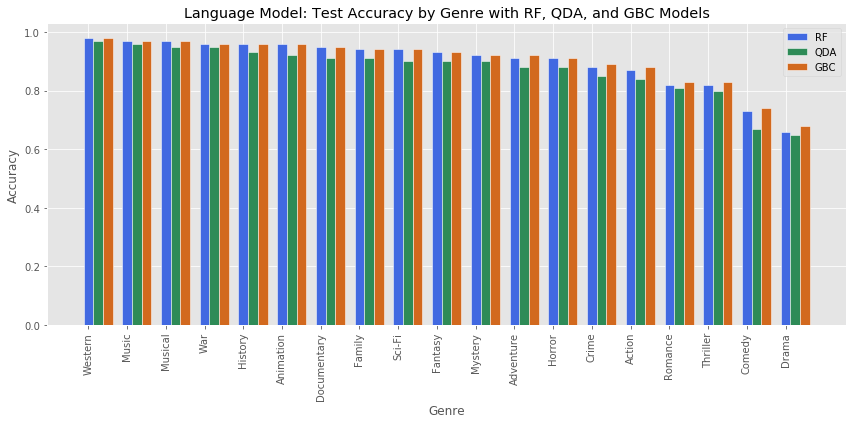

In [76]:
### plot genre accuracy for RF vs. QDA
test_accu_all_rf_df = test_accu_all_rf_df.sort_values(by = 'Accuracy', 
                                                      ascending = False)
test_accu_all_qda_df = test_accu_all_qda_df.sort_values(by = 'Accuracy', 
                                                        ascending = False)
test_accu_all_gbc_df = test_accu_all_gbc_df.sort_values(by = 'Accuracy', 
                                                        ascending = False)

width = 0.25

print
fig = plt.figure(figsize = (12, 6))

ax = fig.add_subplot(1, 1, 1)
rects_1 = ax.bar(range(num_genres), 
       test_accu_all_rf_df.Accuracy, width = width, color = 'royalblue', 
       edgecolor = 'white')
rects_2 = ax.bar(np.repeat(0.25, num_genres) + range(num_genres), 
       test_accu_all_qda_df.Accuracy, width = width, color = 'seagreen', 
       edgecolor = 'white')
rects_3 = ax.bar(np.repeat(0.5, num_genres) + range(num_genres), 
       test_accu_all_gbc_df.Accuracy, width = width, color = 'chocolate', 
       edgecolor = 'white')
ax.set_xticks(range(num_genres))
ax.set_xticklabels(test_accu_all_rf_df.index.values, rotation = 90)
ax.set_xlabel("Genre")
ax.set_ylabel("Accuracy")
ax.set_title("Language Model: Test Accuracy by Genre with RF, QDA, and GBC Models")
ax.legend((rects_1[0], rects_2[0], rects_3[0]), ('RF', 'QDA', 'GBC'))

plt.tight_layout()
plt.show()

#### Comparing Metrics with Random Forest, QDA, and Boosting

In [77]:
all_metrics = pd.concat([rf_metrics, qda_metrics, gbc_metrics], axis = 0)
accuracy_metrics = all_metrics[all_metrics.Metric == 'Accuracy']
precision_metrics = all_metrics[all_metrics.Metric == 'Precision']
recall_metrics = all_metrics[all_metrics.Metric == 'Recall']
hamming_metrics = all_metrics[all_metrics.Metric == 'Hamming Loss']

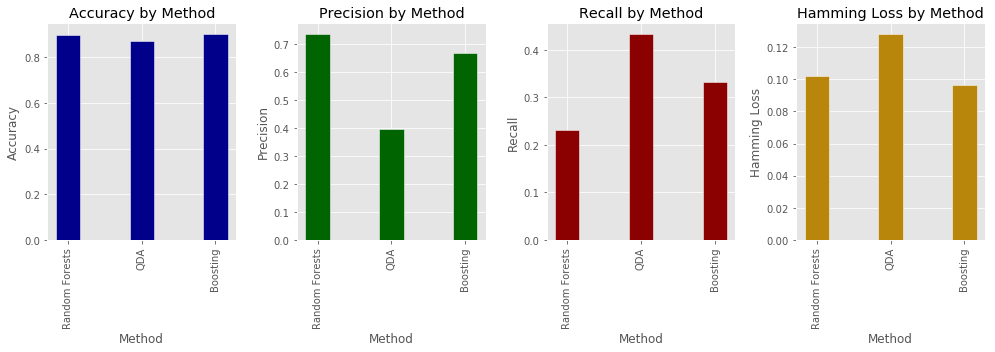

In [78]:
width = 0.33
num_models = accuracy_metrics.shape[0]

print
fig = plt.figure(figsize = (14, 5))

ax1 = fig.add_subplot(1, 4, 1)
ax1.bar(range(num_models), accuracy_metrics.Value, width = width, color = 'darkblue', 
       edgecolor = 'white')
ax1.set_xticks(range(num_models))
ax1.set_xticklabels(accuracy_metrics.Method, rotation = 90)
ax1.set_xlabel("Method")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy by Method")

ax2 = fig.add_subplot(1, 4, 2)
ax2.bar(range(num_models), precision_metrics.Value, width = width, color = 'darkgreen', 
       edgecolor = 'white')
ax2.set_xticks(range(num_models))
ax2.set_xticklabels(precision_metrics.Method, rotation = 90)
ax2.set_xlabel("Method")
ax2.set_ylabel("Precision")
ax2.set_title("Precision by Method")
              
ax3 = fig.add_subplot(1, 4, 3)
ax3.bar(range(num_models), recall_metrics.Value, width = width, color = 'darkred', 
       edgecolor = 'white')
ax3.set_xticks(range(num_models))
ax3.set_xticklabels(recall_metrics.Method, rotation = 90)
ax3.set_xlabel("Method")
ax3.set_ylabel("Recall")
ax3.set_title("Recall by Method")
              
ax4 = fig.add_subplot(1, 4, 4)
ax4.bar(range(num_models), hamming_metrics.Value, width = width, color = 'darkgoldenrod', 
       edgecolor = 'white')
ax4.set_xticks(range(num_models))
ax4.set_xticklabels(hamming_metrics.Method, rotation = 90)
ax4.set_xlabel("Method")
ax4.set_ylabel("Hamming Loss")
ax4.set_title("Hamming Loss by Method")
      
plt.tight_layout()
plt.show()

### Ensemble Models

#### Function to Fit and Score a Stacked Model

In [79]:
# function to fit and score a stacking model
def fit_score_stacking(models, combiner, x_train, y_train, x_test, y_test):
    
    #----- fit model
    
    num_models = len(models)
    n_train = x_train.shape[0]
    n_test = x_test.shape[0]
    
    # create variables to hold predictions
    y_train_stack = np.zeros((n_train, num_models))
    y_test_stack = np.zeros((n_test, num_models))
    y_predict = np.zeros(n_test)
    
    # predict with each model on training and testing data
    for index in range(num_models):
        model = models[index]
        
        long_name = str(type(model))
        short_name = re.sub('.*\.', '', long_name)
        short_name = re.sub('\'>', '', short_name)
        
        this_num_pc = num_pc_qda if short_name == "QuadraticDiscriminantAnalysis" else num_pc
        y_train_stack[:, index] = model.predict_proba(x_train[:, :this_num_pc])[:, 1]
        y_test_stack[:, index] = model.predict_proba(x_test[:, :this_num_pc])[:, 1]
    
    # predict with combined models
    combiner.fit(y_train_stack, y_train)
    y_test_predict = combiner.predict(y_test_stack)
    
    #----- score model
    
    test_accu = (y_test_predict == y_test).sum() / float(n_test)
    
    y_test_null_predict = np.zeros([y_test.shape[0]])
    test_null_accu = (y_test.values == y_test_null_predict).sum() / float(y_test.shape[0])
    
    test_positives = y_test_predict.sum()
    
    test_precision = precision_score(y_test, y_test_predict, average = 'binary')
    
    test_recall = recall_score(y_test, y_test_predict, average = 'binary')
    
    test_hamming = hamming_loss(y_test, y_test_predict)
    
    return test_accu, test_null_accu, test_precision, test_recall, \
        test_hamming, test_positives

#### Different Genre Types - Stacked Models

In [80]:
y_predict_all_stack = np.zeros([x_test.shape[0], num_genres])
test_accu_all_stack = np.zeros(num_genres)
test_null_accu_all_stack = np.zeros(num_genres)
test_precision_all_stack = np.zeros(num_genres)
test_recall_all_stack = np.zeros(num_genres)
test_hamming_all_stack = np.zeros(num_genres)
test_positives_all_stack = np.zeros(num_genres)

# fit and score model on each genre
combiner = RFC()
for i in range(num_genres):
    models = [models_rf[i], models_qda[i], models_log_reg[i], models_lda[i],
             models_gbc[i], models_nb[i]]
    
    test_accu_all_stack[i], test_null_accu_all_stack[i], test_precision_all_stack[i], \
    test_recall_all_stack[i], test_hamming_all_stack[i], test_positives_all_stack[i] = \
        fit_score_stacking(models, combiner,
                           x_train_pca, y_train.iloc[:, i], 
                           x_test_pca, y_test.iloc[:, i])

#### Average Test Metrics with Stacking

In [81]:
stack_metrics = display_metrics(test_accu_all_stack, test_null_accu_all_stack, 
                                test_precision_all_stack, test_recall_all_stack, 
                                test_hamming_all_stack)

,Metric,Value
0,Accuracy,0.8973
1,Null Accuracy,0.8761
2,Precision,0.6858
3,Recall,0.2535
4,Hamming Loss,0.1027
